In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os # makes you access your files on hard drive outside the folder


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_curve, precision_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

In [360]:
dfc = pd.read_csv('data/client_train.csv')
dfi = pd.read_csv('data/invoice_train.csv')

In [361]:
dfc['client_id'] = dfc['client_id'].apply(lambda x: x.replace('train_Client_', ''))
dfi['client_id'] = dfc['client_id'].apply(lambda x: x.replace('train_Client_', ''))

In [362]:
dfc.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')

In [363]:
# we check the values for certain columns and decider, wether we transform them to categorical or not.
dfi.tarif_type= dfi.tarif_type.astype('category')
#dfi.counter_type = dfi.counter_type.astype('category')
#dfi.counter_code = dfi.counter_code.astype('category')
dfi.reading_remarque = dfi.reading_remarque.astype('category')
dfc.region = dfc.region.astype('category')
dfc.disrict = dfc.disrict.astype('category')
dfc.client_catg = dfc.client_catg.astype('category')



# some columns can be reduced to int8, to save memory.
dfi.counter_coefficient = dfi.counter_coefficient.astype('int8')
dfi.months_number = dfi.months_number.astype('int16')

dfi.consommation_level_4 = dfi.consommation_level_4.astype('int32')
dfi.consommation_level_3 = dfi.consommation_level_3.astype('int32')
dfi.consommation_level_2 = dfi.consommation_level_2.astype('int32')
dfi.consommation_level_1 = dfi.consommation_level_1.astype('int32')

# dfi.counter_statue.value_counts()
dfi.counter_statue = dfi.counter_statue.astype('category')

In [364]:
dfi.drop(dfi[dfi['months_number'] > 48].index, axis=0, inplace=True)

list_erroneous_month_clients = dfi.query("months_number > 48").client_id.tolist() ### why? 

In [365]:
# we also want to get rid of the erroneous <0 month numbers
dfi.drop(dfi[dfi['months_number'] < 1].index, axis=0, inplace=True)


In [366]:
#Have to clean up the counter_statue column cause Decision tree gets upset converting the string to a float

#I'm wondering now if the 0s are actually all missing values, kinda

dfi.counter_statue.unique().tolist()
dfi.counter_statue.replace({'4' : 4, '5' : 5, '0' : 0, '1' : 1, 'A' : 6, 618 : 6, 420 : 6 }, inplace=True)

dfi.counter_type.replace({"ELEC":0,"GAZ":1}, inplace=True)
dfi.counter_statue.unique()

[0, 1, 5, 4, 3, 2, 6]
Categories (10, int64): [0, 1, 2, 3, ..., 46, 6, 769, 269375]

In [367]:
dfi.reading_remarque.value_counts()
dfi.reading_remarque.replace({413 : 7, 5 : 7}, inplace=True)

In [368]:
#Let's generate the avg monthly use column

dfi.eval('avg_month_use = (new_index - old_index) / months_number ', inplace=True)

In [369]:
x = dfc.drop('target', axis=1)  # split on the client id 
y = dfc['target']
#list_of_targets = dfc.query('target == 1').client_id.tolist()
#y = pd.Series(dfi.client_id.isin(list_of_targets))

In [370]:
X_train_client, X_test_client , y_train_client, y_test_client = train_test_split(x, y, stratify=y, random_state=42)

In [371]:
x_train_alt = pd.concat([X_train_client, dfi], join='inner', axis =1).drop(['creation_date', 'old_index', 'new_index', 'months_number'], axis=1)
# might have to include invoice date for the regular descision tree

In [372]:
x_test_alt = pd.concat([X_test_client, dfi], join='inner', axis =1).drop(['creation_date', 'old_index', 'new_index', 'months_number'], axis=1)
# might have to include invoice date for the regular descision tree  and 'counter_number',

In [373]:
y_train = pd.concat([y_train_client, dfi], join='inner', axis =1)['target']

In [374]:
y_test = pd.concat([y_test_client, dfi], join='inner', axis =1)['target']

In [375]:
x_train = x_train_alt.drop('client_id', axis=1)
x_test = x_test_alt.drop('client_id', axis=1)

tree = DecisionTreeClassifier(random_state=42, )
tree.fit(x_train, y_train)

y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

In [376]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score

In [377]:
print(f'This is the classification report for our training data \n {classification_report(y_train, y_train_pred)}\n'
        f'the classification report for our testing data\n {classification_report(y_test, y_test_pred)}\n')

This is the classification report for our training data 
               precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     95845
         1.0       0.13      0.72      0.22      5669

    accuracy                           0.72    101514
   macro avg       0.56      0.72      0.53    101514
weighted avg       0.93      0.72      0.80    101514

the classification report for our testing data
               precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     31944
         1.0       0.07      0.39      0.12      1892

    accuracy                           0.69     33836
   macro avg       0.51      0.55      0.47     33836
weighted avg       0.90      0.69      0.77     33836




In [378]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [379]:
# for XGBoost we need to encode the data 

In [380]:
x_train.columns

Index(['disrict', 'client_catg', 'region', 'invoice_date', 'tarif_type',
       'counter_number', 'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'counter_type',
       'avg_month_use'],
      dtype='object')

In [381]:
#which columns to get dummies from 
dummies = ['disrict', 'client_catg', 'region', 'tarif_type', 'counter_statue', 'reading_remarque' ]


In [382]:
dummy_train = pd.get_dummies(x_train[dummies], dtype='int', drop_first=True)
dummy_train
x_train_final = pd.concat([dummy_train, x_train.drop(dummies, axis=1)], axis=1)


In [383]:
x_train_final['invoice_date'] = pd.to_datetime(x_train_final['invoice_date'], format='%Y-%m-%d').astype(int)

In [384]:
dummy_test = pd.get_dummies(x_test[dummies], dtype='int', drop_first=True)
dummy_test
x_test_final = pd.concat([dummy_test, x_test.drop(dummies, axis=1)], axis=1)


In [385]:
x_test_final['invoice_date'] = pd.to_datetime(x_test_final['invoice_date'], format='%Y-%m-%d').astype(int)

In [386]:
model1 = XGBClassifier(scale_pos_weight= len(y[y == 0]) / len(y[y == 1]) , max_delta_step=1)
model1.fit(x_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, ...)

In [387]:
y_train_pred = model1.predict(x_train_final)
y_test_pred = model1.predict(x_test_final)

In [388]:
print(f'This is the classification report for our training data \n {classification_report(y_train, y_train_pred)}\n'
        f'the classification report for our testing data\n {classification_report(y_test, y_test_pred)}\n')

This is the classification report for our training data 
               precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     95845
         1.0       0.13      0.72      0.22      5669

    accuracy                           0.72    101514
   macro avg       0.56      0.72      0.53    101514
weighted avg       0.93      0.72      0.80    101514

the classification report for our testing data
               precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     31944
         1.0       0.07      0.39      0.12      1892

    accuracy                           0.69     33836
   macro avg       0.51      0.55      0.47     33836
weighted avg       0.90      0.69      0.77     33836




In [389]:
grid_params = {'max_depth': [5, 10, 15, 20 ,25, 30 , 45, 50 ], 
                'learning_rate':  [0.01 , 0.05, 0.1, 0.15, 0.2],
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                'reg_alpha': [0, 0.0001, 0.005, 0.01, 0.05],
                #'reg_lambda': [0.1, 0.5, 1, 5, 10]
               }


In [390]:
random_search = RandomizedSearchCV(estimator=XGBClassifier(scale_pos_weight= len(y[y == 0]) / len(y[y == 1]) , max_delta_step=1), 
                                    param_distributions=grid_params,
                                    scoring='recall', 
                                    verbose=3,
                                    n_jobs=-1)

In [391]:
random_search.fit(x_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.15, max_depth=30, reg_alpha=0;, score=0.014 total time= 2.2min
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.15, max_depth=30, reg_alpha=0;, score=0.015 total time= 2.2min
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.15, max_depth=30, reg_alpha=0;, score=0.011 total time= 2.2min
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.15, max_depth=30, reg_alpha=0;, score=0.012 total time= 2.2min
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.15, max_depth=30, reg_alpha=0;, score=0.013 total time= 2.2min
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.01, max_depth=30, reg_alpha=0.005;, score=0.079 total time= 3.5min
[CV 2/5] END colsample_bytree=0.9, learning_rate=0.01, max_depth=30, reg_alpha=0.005;, score=0.090 total time= 3.6min
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.01, max_depth=30, reg_alpha=0.005;, score=0.095 total time= 3.6min
[CV 1/5] END co

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 45,
                                                      50],
                                        'reg_alpha': [0, 0.0001, 0.005, 0.01,
                                                      0.05]},
                   scoring='recall', verbose=3)

In [392]:
best_params = random_search.best_params_

In [393]:
print(f' these are the optimal parameters : {random_search.best_params_} \n resulting in an accuracy of: {random_search.best_score_}')

 these are the optimal parameters : {'reg_alpha': 0.0001, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7} 
 resulting in an accuracy of: 0.4275857667443428


In [394]:
model_best = XGBClassifier(**best_params)

In [395]:
model_best.fit(x_train_final, y_train)
y_train_pred = model_best.predict(x_train_final)
y_test_pred = model_best.predict(x_test_final)

In [396]:
print(f' the classification report for out training set with the best model {classification_report(y_train_pred, y_train_pred)}\n '
      f' and the report on our Test data {classification_report(y_test, y_test_pred )}')

 the classification report for out training set with the best model               precision    recall  f1-score   support

           0       1.00      1.00      1.00    101510
           1       1.00      1.00      1.00         4

    accuracy                           1.00    101514
   macro avg       1.00      1.00      1.00    101514
weighted avg       1.00      1.00      1.00    101514

  and the report on our Test data               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     31944
         1.0       0.00      0.00      0.00      1892

    accuracy                           0.94     33836
   macro avg       0.47      0.50      0.49     33836
weighted avg       0.89      0.94      0.92     33836



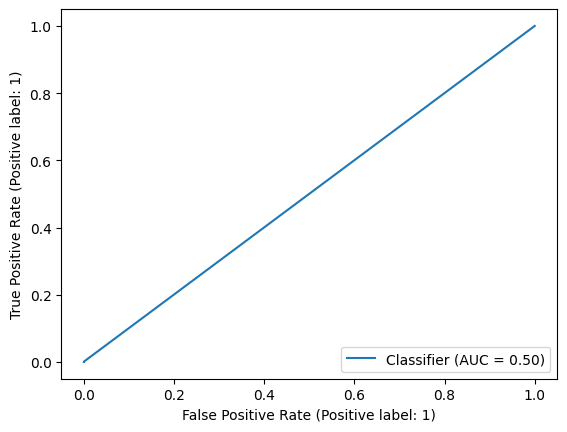

In [407]:
roc_curve(y_train, y_train_pred)
RocCurveDisplay.from_predictions(y_train,y_train_pred)

In [409]:
y_test_prob = model1.predict_proba(x_test_final)

y_test_prob

array([[0.2742315 , 0.7257685 ],
       [0.47010827, 0.5298917 ],
       [0.4751857 , 0.5248143 ],
       ...,
       [0.51755416, 0.48244584],
       [0.49924046, 0.50075954],
       [0.43249667, 0.56750333]], dtype=float32)

In [414]:
x_test_alt['predictions_1'] = y_test_prob[: , 1]

In [415]:
x_test_alt['tresh'] = x_test_alt['predictions_1'].apply(lambda x: 1 if x  >= 0.5 else 0)
x_test_alt

,disrict,client_id,client_catg,region,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type,avg_month_use,predictions_1,tresh
55911,69,28374,11,103,28374,2005-11-29,11,586603,0,203,6,1,369,0,0,0,0,92.25,0.725769,1
105078,69,72624,11,107,72624,2014-01-16,11,798133,0,203,9,1,633,0,0,0,0,158.25,0.529892,1
87970,69,57227,11,107,57227,2010-05-08,11,635926,0,203,6,1,305,0,0,0,0,76.25,0.524814,1
77202,69,47536,11,103,47536,2012-05-03,40,95697,0,5,6,1,105,0,0,0,1,26.25,0.563624,1
40801,69,14775,11,107,14775,2008-11-20,11,1086962,0,207,6,1,533,0,0,0,0,133.25,0.420430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129141,63,94281,11,311,94281,2006-07-21,11,804350,0,203,6,1,597,0,0,0,0,149.25,0.623329,1
16080,62,114469,11,309,114469,2006-04-20,40,6778398,0,5,6,1,149,0,0,0,1,37.25,0.466426,0
81165,69,51101,11,104,51101,2016-07-20,40,4164508,0,5,6,1,89,0,0,0,1,22.25,0.482446,0
55106,69,2765,11,107,2765,2009-07-23,11,924007,0,203,6,1,294,0,0,0,0,73.50,0.500760,1


In [399]:
# if a client has more than 2 fraud invoices the client will be predicted as fraud 
x_test_alt.groupby('client_id').agg()

,disrict,client_id,client_catg,region,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type,avg_month_use,tresh
55911,69,28374,11,103,28374,2005-11-29,11,586603.0,0,203.0,6,1.0,369.0,0.0,0.0,0.0,0.0,92.25,NaN
105078,69,72624,11,107,72624,2014-01-16,11,798133.0,0,203.0,9,1.0,633.0,0.0,0.0,0.0,0.0,158.25,NaN
87970,69,57227,11,107,57227,2010-05-08,11,635926.0,0,203.0,6,1.0,305.0,0.0,0.0,0.0,0.0,76.25,NaN
77202,69,47536,11,103,47536,2012-05-03,40,95697.0,0,5.0,6,1.0,105.0,0.0,0.0,0.0,1.0,26.25,NaN
40801,69,14775,11,107,14775,2008-11-20,11,1086962.0,0,207.0,6,1.0,533.0,0.0,0.0,0.0,0.0,133.25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
33832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
33833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
33834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [400]:
final_result.groupby('counter_number')